In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from pysr3.linear.models import LinearL1ModelSR3
from datetime import datetime



#### SPY options

In [95]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [96]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
# calls=calls[calls['time_to_exp']<0.8]
calls=calls.sort_index()[::-1]


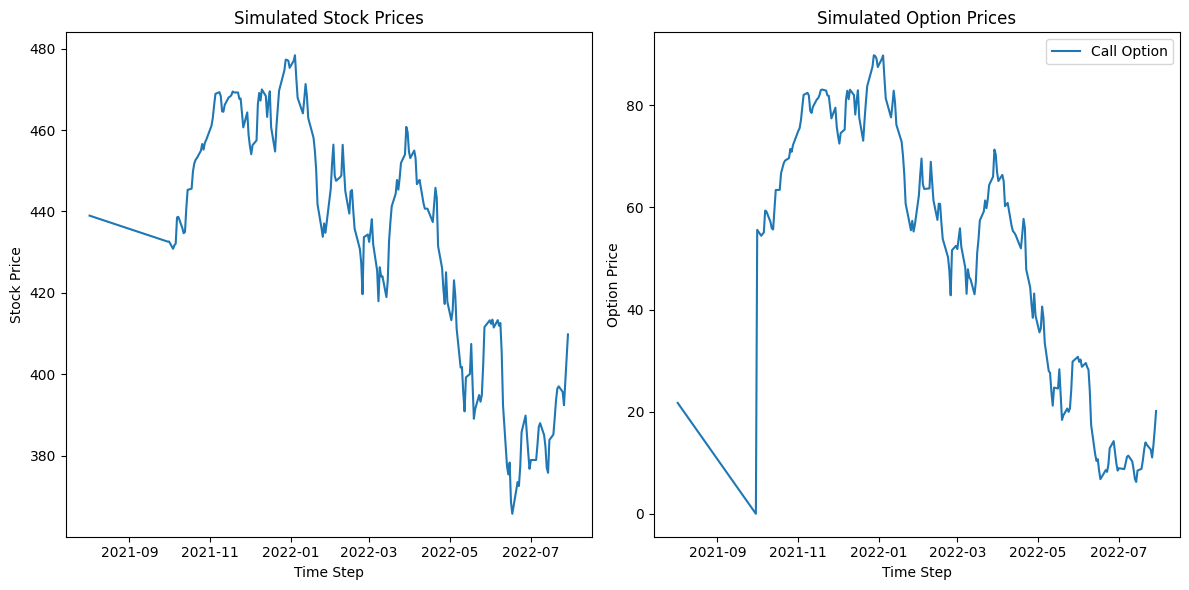

In [97]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [91]:
u = calls['price'].values.reshape(-1,1)
dt = calls['time_to_exp'].values.reshape(-1,1)
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

### Synthetic Option

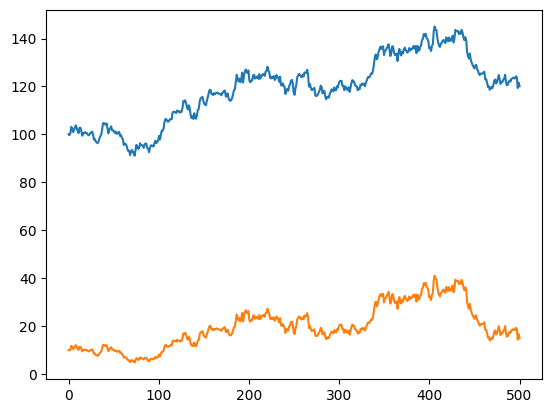

In [173]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date

def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# lognormal distribution of the price
S0 = 100
r = 0.05  
sigma = 0.25
K = 105
T = 1.0  

# Monte Carlo simulation
n_steps = 500
timespace = np.linspace(0,n_steps,n_steps)
dt = T/n_steps  
S = np.zeros(n_steps)  
C = np.zeros(n_steps)  

S[0] = S0
C[0] = black_scholes_call(S[0],K,T,r,sigma)
for step in range(1, len(timespace)):
    t = step / n_steps  # Time at this step
    Z = np.random.normal()
    S[step] = S[step-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z)
    C[step] = black_scholes_call(S[step],K,T-t,r,sigma)

plt.plot(timespace,S)
plt.plot(timespace,C)

In [183]:
u = C.reshape(-1,1)
u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

In [184]:
u.shape

(500, 1)

### PySINDy

In [176]:
# smooth_fd=ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5})
stlsq =  ps.STLSQ(
        threshold=0,
        alpha=0,
        max_iter=20,
        normalize_columns=True,
        ridge_kw={"tol": 1e-10},
    )

# Define PDE library that is linear in u and defined up to second derivatives spacially
library_functions = [lambda x: x, lambda x: x * x ]
library_function_names = [lambda x: x, lambda x: x+x ]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2, # constrain up to second-order derivatives 
    spatial_grid=S, # underlying values 
)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.001, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u,x_dot = u_dot, t=dt)
model.print()


# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('Lasso model: ')
optimizer = Lasso(alpha=2.5,fit_intercept=False,max_iter=5000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u,x_dot = u_dot, t=dt)
model.print()


STLSQ model: 
(x0)' = 0.965 x0 + -0.046 x0x0 + 30.612 x0_1 + 2.984 x0_11 + -3.369 x0x0_1 + 0.090 x0x0x0_1 + -0.291 x0x0_11 + 0.007 x0x0x0_11
Lasso model: 
(x0)' = 0.439 x0 + -0.018 x0x0 + 0.004 x0x0x0_1 + 0.001 x0x0x0_11


In [194]:
pde_lib.get_feature_names()

['x0', 'x0x0', 'x0_1', 'x0_11', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11']

In [31]:
model = ps.SINDy(feature_library=pde_lib, optimizer=lasso_optimizer)

model.fit(calls['price'].values.reshape(-1,1), t=calls['time_to_exp'].values)
model.print()

(x0)' = 3.858 x0 + -130.886 x0_1 + -82.290 x0_11 + 3.515 x0x0_1 + 2.646 x0x0_11


### Building Library

In [206]:
def ConvSmoother(x, p, sigma):
    """
    Smoother for noisy data
    
    Inpute = x, p, sigma
    x = one dimensional series to be smoothed
    p = width of smoother
    sigma = standard deviation of gaussian smoothing kernel
    """
    
    n = len(x)
    y = np.zeros(n, dtype=np.float64)
    g = np.exp(-np.power(np.linspace(-p,p,2*p),2)/(2.0*sigma**2))

    for i in range(n):
        a = max([i-p,0])
        b = min([i+p,n])
        c = max([0, p-i])
        d = min([2*p,p+n-i])
        y[i] = np.sum(np.multiply(x[a:b], g[c:d]))/np.sum(g[c:d])
        
    return y


def calculate_backward_difference(series):
    series = ConvSmoother(series,len(series)//10,2)
    backward_differences = np.array([series[i] - series[i-1] for i in range(1, len(series))])
    return backward_differences


def build_differentiate_library(variables, variable_names, max_degree=2, smoothing_factor=0.01):
    '''
    Build a differentiate library until dth degree calculating partial derivative of y in respect to X using smoothed finite difference method (backward difference)
    '''
    dx = calculate_backward_difference(variables[0])
    dy = np.concatenate(([0],calculate_backward_difference(variables[1])))
    derivatives = [dy]
    derivative_variable_names = [f'{variable_names[1]}_t'] 

    for var, var_name in zip(variables, variable_names):
        derivatives.append(var)
        derivative_variable_names.append(var_name)
    

    for degree in range(1, max_degree + 1):
        current_derivative = calculate_backward_difference(derivatives[-1])/dx
        current_derivative_smoothed = current_derivative
        derivatives.append(np.concatenate(([0], current_derivative_smoothed)))
        derivative_variable_names.append(f"{variable_names[-1]}_{variable_names[0]*degree}")

    return derivatives, derivative_variable_names

def build_polynomial_library(variables, variable_names, max_degree=2):
    '''
    Build a Polynomial library with variables until max_degree and cross-terms
    '''

    original_vars = zip(variables, variable_names)
    print(original_vars)
    for degree in range(2, max_degree + 1):
        for var, var_name in original_vars:
            variables = np.append([var ** degree],variables,axis=0)
            variable_names.append(f"({var_name})^{degree}")


    return variables , variable_names

def build_cross_library(variables, variable_names):
    lib_temp = []
    v_name_temp = []

    for i in range(len(variable_names)):
        lib_temp.append(variables[i])
        v_name_temp.append(f"{variable_names[i]}")
        for j in range(i + 1, len(variable_names)):
            lib_temp.append(variables[i] * variables[j])
            v_name_temp.append(f"({variable_names[i]}) * ({variable_names[j]})")
    
    return lib_temp,v_name_temp

In [172]:
variable_names = ['S', 'V']

price = list(C)
underlying = list(S)
# tal = df['TimeToExpire'].values

In [209]:
# derivatives_values,derivatives_names = build_differentiate_library([underlying,price],variable_names,max_degree=2)

library_values = np.array(derivatives_values[1:])
library_names = derivatives_names[1:] #Exclude The first derivative

# y = np.array(library_values[1]).reshape(-1,1)

library_values,library_names = build_polynomial_library(library_values,library_names, max_degree=2)

library_values,library_names = build_cross_library(library_values,library_names)

### Fitting Model

In [216]:
def iterative_threshold_ridge(X, y, threshold=0.1, alpha=1.0, max_iterations=10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    remaining_coeffs = np.zeros(X.shape[1])
    remaining_indices = np.array(range(X.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    for _ in range(max_iterations):
        model = Ridge(fit_intercept = False,alpha=alpha)
        model.fit(X_train, y_train)
        coeffs = model.coef_[0]
        remaining_indices_temp = np.where(np.abs(coeffs) >= threshold)
        if len(remaining_indices_temp[0]) == 0:
            print(f'threshold ({threshold}) is forcing coefficients towards 0 with alpha factor {alpha}')
            break

        remaining_indices = remaining_indices[remaining_indices_temp]
        X_train = X_train[:, remaining_indices_temp[0]]

    remaining_coeffs[remaining_indices] = coeffs
    X_test = X_test[:, remaining_indices]
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print(final_rmse)
    return remaining_coeffs,final_rmse


def SINDy_regression(X, y, opt = ps.STLSQ, **kwargs):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    opt = opt(**kwargs)
    lib = ps.IdentityLibrary()

    model = ps.SINDy(feature_library=lib, optimizer=opt)
    model.fit(X_train, x_dot = y_train)

    remaining_coeffs = model.coefficients()
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print(final_rmse)
    return remaining_coeffs,final_rmse


def SR3_regression(X, y, lam=1.0,el=1e5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LinearL1ModelSR3(lam=lam,el = el)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse


def lasso_regression(X, y, alpha=1.0):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = Lasso(alpha=alpha)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse

def elastic_net_regression(X, y, alpha=1.0, l1_ratio=0.5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse

def print_pde(w, rhs_description, ut='u_t', threshold=1e-6):
    pde = ut + ' = '
    terms = []

    for i in range(len(w)):
        if abs(w[i].real) > threshold:
            terms.append("(%05f)" % w[i].real + rhs_description[i] + '\n')

    if terms:
        pde += ' + '.join(terms)
        pde = pde.replace('+ -', '- ')
    else:
        return None

    return pde

In [ ]:
smooth_fd=ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5})


### TESTES

threshold (0.1577777777777778) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.1596969696969697) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.16161616161616163) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.16353535353535353) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.16545454545454547) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.16737373737373737) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.1692929292929293) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.17505050505050507) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.17696969696969697) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.1788888888888889) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.1808080808080808) is forcing coefficients towards 0 with alpha factor 0.0
threshold (0.18272727272727274) is fo

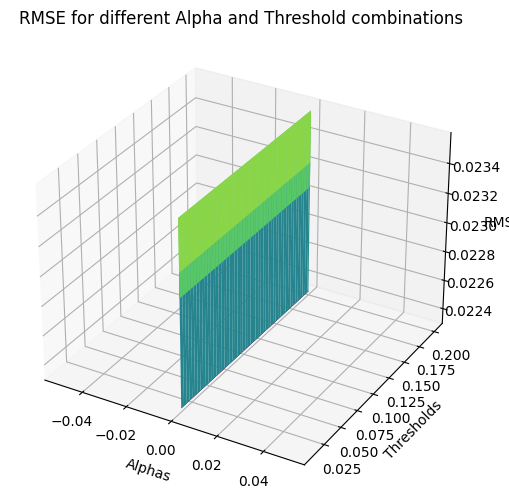

In [231]:
# Solve with STRidge
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]

feature_names = library_names
alphas = [0]
thresholds = np.linspace(0.01,.2,100)

grid = np.array(np.meshgrid(alphas, thresholds)).T.reshape(-1, 2)

best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, threshold = obj
    w,best_rmse = iterative_threshold_ridge(X,y,threshold=threshold,alpha=alpha)
    pdes.append(print_pde(w,feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(rmses[best_idx])
print(pdes[best_idx])
# Create meshgrid for 3D plot
alpha_mesh, threshold_mesh = np.meshgrid(alphas, thresholds)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(thresholds))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, threshold_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")

plt.show()


PDE derived using STRidge
0.022323707002201407
None


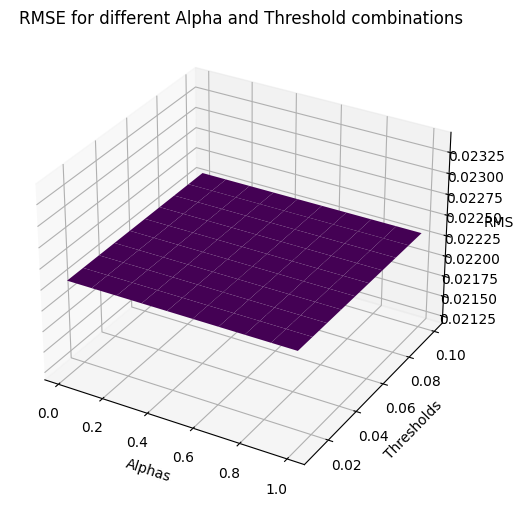

In [229]:
# Solve with PySINDy
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]

feature_names = library_names
alphas = np.linspace(0.01,1.,10)
thresholds = np.linspace(0.01,0.1,10)

grid = np.array(np.meshgrid(alphas, thresholds)).T.reshape(-1, 2)

best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, threshold = obj
    w,best_rmse = SINDy_regression(X,y,opt = ps.SR3, nu=alpha,thresholder = 'L1',max_iter = 10000)
    pdes.append(print_pde(w[0],feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(rmses[best_idx])
print(pdes[best_idx])
# Create meshgrid for 3D plot
alpha_mesh, threshold_mesh = np.meshgrid(alphas, thresholds)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(thresholds))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, threshold_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")
plt.show()


PDE derived using Lasso
0.0004981039364773366
V_t = (0.000671)S
 + (0.000570)(S) * (V)
 + (-0.001342)(S) * (V_S)
 + (0.000691)(S) * (V_SS)
 + (0.000003)(S) * ((S)^2)
 + (-0.000192)(S) * ((V)^2)
 + (-0.001321)(S) * ((V_S)^2)
 + (0.000870)(S) * ((V_SS)^2)
 + (-0.000672)V
 + (0.000156)(V) * (V_S)
 + (-0.000040)(V) * (V_SS)
 + (-0.000036)(V) * ((S)^2)
 + (0.000395)(V) * ((V)^2)
 + (0.000458)(V) * ((V_S)^2)
 + (-0.001040)(V) * ((V_SS)^2)
 + (0.001903)V_S
 + (-0.002428)(V_S) * (V_SS)
 + (0.000814)(V_S) * ((S)^2)
 + (0.000512)(V_S) * ((V)^2)
 + (0.000336)(V_S) * ((V_S)^2)
 + (0.000624)(V_S) * ((V_SS)^2)
 + (0.000668)V_SS
 + (0.003388)(V_SS) * ((S)^2)
 + (-0.006056)(V_SS) * ((V)^2)
 + (0.004485)(V_SS) * ((V_S)^2)
 + (-0.001403)(V_SS) * ((V_SS)^2)
 + (-0.002664)(S)^2
 + (0.001752)((S)^2) * ((V)^2)
 + (-0.002108)((S)^2) * ((V_S)^2)
 + (0.001082)((S)^2) * ((V_SS)^2)
 + (0.002446)(V)^2
 + (-0.001038)((V)^2) * ((V_S)^2)
 + (-0.000870)((V)^2) * ((V_SS)^2)
 + (-0.002444)(V_S)^2
 + (-0.001912)((V_S)^2

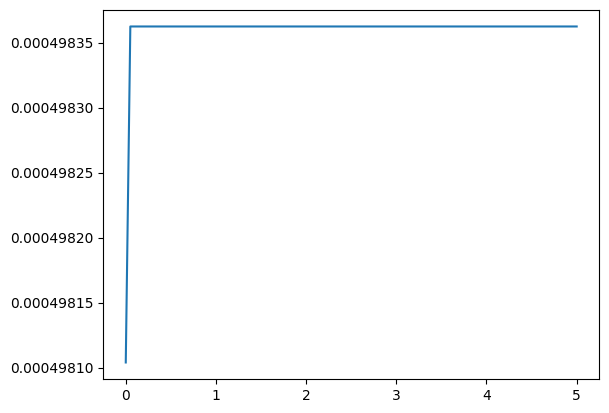

In [227]:
# Solve with Lasso
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]


feature_names = library_names
alphas =  np.linspace(0,100,100)
best = float('inf')
pdes = []
rmses = []

for idx, alpha in enumerate(alphas):
    w,best_rmse = lasso_regression(X, y,alpha = alpha)
    pdes.append(print_pde(w,feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using Lasso")
plt.plot(alphas,rmses)
print(rmses[best_idx])
print(pdes[best_idx])

PDE derived using Elastic-Net
None
0.0004983623531401848


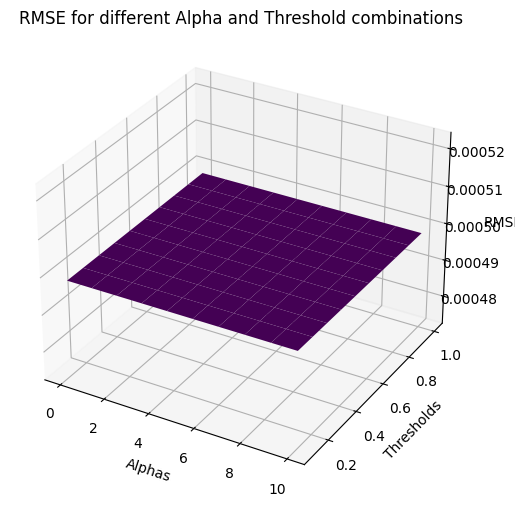

In [140]:
# Solve with Elastic-Net
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]


feature_names = library_names
alphas = np.linspace(0.01,10.,10)
l1s = np.linspace(0.1,1.,10)

grid = np.array(np.meshgrid(alphas, l1s)).T.reshape(-1, 2)
best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, l1 = obj
    w,best_rmse = elastic_net_regression(X, y,alpha = alpha,l1_ratio = l1)
    pdes.append(print_pde(w,feature_names ,'d(V)'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using Elastic-Net")
print(pdes[best_idx])
print(rmses[best_idx])

# Create meshgrid for 3D plot
alpha_mesh, l1_mesh = np.meshgrid(alphas, l1s)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(l1s))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, l1_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")

plt.show()


In [228]:
# Solve with SR3
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0])[6:]


feature_names = library_names
lambdas = np.linspace(0.1,10,10)
els = np.linspace(0.01,1.,10)

grid = np.array(np.meshgrid(lambdas, els)).T.reshape(-1, 2)
best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    lam, l1 = obj
    w,best_rmse = SR3_regression(X, y,lam = lam,el = l1)
    pdes.append(print_pde(w['x'],feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(pdes[best_idx])
print(rmses[best_idx])

# Create meshgrid for 3D plot
lam_mesh, el_mesh = np.meshgrid(lambdas, els)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(lambdas), len(els))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(lam_mesh, el_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Lambda')
ax.set_ylabel('V')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Lambda and V combinations")

plt.show()


MemoryError: Unable to allocate 47.7 GiB for an array with shape (79995, 79995) and data type float64

In [ ]:
for p in pdes:
    if p is not None:
        print(p)

V_t = (0.125189)(V) * (V_S)

V_t = (0.227879)(V) * (V_S)

V_t = (0.298154)(V) * (V_S)

V_t = (-0.085321)(S) * (V)
 + (-0.102621)(S) * (V_SS)
 + (0.393950)(V) * (V_S)

V_t = (-0.175914)(S) * (V)
 + (-0.186423)(S) * (V_SS)
 + (0.480710)(V) * (V_S)

V_t = (-0.251041)(S) * (V)
 + (-0.253775)(S) * (V_SS)
 + (0.551957)(V) * (V_S)

V_t = (-0.314339)(S) * (V)
 + (-0.311754)(S) * (V_SS)
 + (0.611953)(V) * (V_S)
 + (0.015895)(V) * (V_SS)

V_t = (-0.368382)(S) * (V)
 + (-0.367382)(S) * (V_SS)
 + (0.664001)(V) * (V_S)
 + (0.064536)(V) * (V_SS)

V_t = (-0.414927)(S) * (V)
 + (-0.414877)(S) * (V_SS)
 + (0.708480)(V) * (V_S)
 + (0.106360)(V) * (V_SS)

V_t = (-0.455395)(S) * (V)
 + (-0.455775)(S) * (V_SS)
 + (0.746843)(V) * (V_S)
 + (0.142674)(V) * (V_SS)

V_t = (-0.490870)(S) * (V)
 + (-0.491255)(S) * (V_SS)
 + (0.780196)(V) * (V_S)
 + (0.174472)(V) * (V_SS)

V_t = (-0.521678)(S) * (V)
 + (-0.521527)(S) * (V_SS)
 + (0.808461)(V) * (V_S)
 + (0.203318)(V) * (V_SS)
 + (-0.015874)(V_S) * (V_SSS)

V_t = (